# DSC 232
Group-Project

Data: NYC FHV (Uber/Lyft)

# Milestone 3
In this milestone, the main task is to perform data pre-processing and training our first model. For simplicity and creating a baseline, we chose to use a Linear Regression model. Overall, it performed well but a different model would likely be better suited for this data. After pre-processing our data for noisy/erroneous data entries, we transformed and encoded our data so that categorical information was handled appropriately. We also scaled our numerical paramters so that they were weighted accurately. The Linear Regression coeffecients are listed at the end of the code.

For further information, please use the link for project README:
https://github.com/RezaMoghadam/Group-Project-Data-NYC-FHV/blob/main/README.md

Under this project, we are working on NYC FHV (For-Hire Vehichle) data which is a detailed record of rides in the NY city between 2019-2022. 
The businesses are Juno, Uber, Lyft, Via, and Lyft. The size of the data in zip format is about 19 GB. We are going to use San Diego Super Computer (SDSC) as a main resource to utilize spark considering the size of the data.


The main step is to start the Spark Session and configure the available resources.

In [1]:
from pyspark.sql import SparkSession

Since the project files are in Parquet format, we use the appropriate app to read them. 

In [2]:
# Create the Spark session
spark = SparkSession.builder \
    .appName("Read Parquet") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "40g") \
    .config("spark.executor.instances", 8) \
    .getOrCreate()

In [3]:
from pyspark.sql.types import DoubleType, IntegerType

# Read the Parquet files without specifying a schema
df = spark.read.parquet("file:///expanse/lustre/projects/uci150/rmoghadam/Data/fhvhv_tripdata_*.parquet")

df.printSchema()

# Show the first few rows
df.show(5)

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_

To see the number of instances

In [4]:
# Get count to determine number of rows
df.count()

745287023

To see the columns

In [5]:
# Get column (parameter) names
df.columns

['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

# Cleaning

Looking at the columns, some of them are not required for the purpose of this milestone which we drop in following step.

In [6]:
# airport fee has erroneous data (double and integer) which makes it difficult to work with
clean_df = df.drop(*[col for col in df.columns if col.endswith("_flag")]+['airport_fee'])


In [7]:
clean_df.show(5)

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+
|           HV0003|              B02867|              B02867|2019-02-01 00:01:26|2019-02-01 00:02:55|2019-02-01 00:05:18|2019-02-01 00:14:57|         245|         251|      2.45|      579|           

We pick the importnat features and remove the rows that have Null values

In [8]:
important_cols = [
    "pickup_datetime", "dropoff_datetime", "trip_miles", "trip_time",
    "base_passenger_fare", "driver_pay", "PULocationID", "DOLocationID"
]

clean_df = clean_df.dropna(subset=important_cols)


In [9]:
from pyspark.sql.functions import col

In [10]:
# Create a function that gets the IQR bounds per feature so that we can later remove outliers
def IQR_bounds(df, columns):
    quantiles = {
        col: df.approxQuantile(col, [0.25, 0.75], 0.01)
        for col in columns
    }
    bounds = {}
    for col, (q1, q3) in quantiles.items():
        iqr = q3 - q1
        bounds[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    return bounds

We remove the rides that have zeros under mile and fare.

In [11]:
clean_df = clean_df.filter(
    "trip_miles > 0 AND trip_time > 0 AND base_passenger_fare >= 0 AND driver_pay >= 0"
)


In [12]:
from pyspark.sql import functions as F

In [13]:
# Function to filter out the outliers
def filter_outliers(df, bounds):
    condition = None
    for col, (lower, upper) in bounds.items():
        col_condition = (F.col(col) >= lower) & (F.col(col) <= upper)
        condition = col_condition if condition is None else (condition & col_condition)
    return df.filter(condition)

In [14]:
from pyspark.sql.functions import hour, dayofweek, unix_timestamp

clean_df = clean_df.withColumn("pickup_hour", hour("pickup_datetime"))
clean_df = clean_df.withColumn("pickup_dayofweek", dayofweek("pickup_datetime"))

In [15]:
# Convert trip_time from seconds to minutes
clean_df = clean_df.withColumn("trip_time", (col('trip_time').cast('double') / 60))

In [16]:
# Sample ~5% of data which should be plenty to identify outlier bounds
sample_df = clean_df.sample(fraction=0.05, seed=77).cache()

In [17]:
sample_df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: double (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_dayofweek: integer (nullable = true)



In [18]:
sample_df.show(5)

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+------------------+-------------------+-----+----+---------+--------------------+----+----------+-----------+----------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|         trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|pickup_hour|pickup_dayofweek|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+------------------+-------------------+-----+----+---------+--------------------+----+----------+-----------+----------------+
|           HV0003|              B02879|              B02879|2019-02-01 00:26:08|2019

In [19]:
sample_df.select('trip_miles','trip_time','base_passenger_fare','tips','driver_pay').summary().show()

+-------+-----------------+--------------------+-------------------+------------------+------------------+
|summary|       trip_miles|           trip_time|base_passenger_fare|              tips|        driver_pay|
+-------+-----------------+--------------------+-------------------+------------------+------------------+
|  count|         37165306|            37165306|           37165306|          37165306|          37165306|
|   mean|4.817895814203685|  18.613717459142805|  20.08944773628104|0.7637775881624675|16.273882912479998|
| stddev|5.556937737134216|  13.248908252754411|  17.85719415576705| 2.518739160154102|14.580484027497253|
|    min|            0.001|0.016666666666666666|                0.0|               0.0|               0.0|
|    25%|              1.6|   9.633333333333333|               9.17|               0.0|              7.38|
|    50%|             2.95|                15.2|              14.96|               0.0|             12.25|
|    75%|             5.91|          

In [20]:
outlier_cols = ['trip_miles','trip_time','base_passenger_fare','tips','driver_pay']

# Get bounds from sample
bounds = IQR_bounds(sample_df, outlier_cols)

# Filter full DataFrame using precomputed bounds
clean_df = filter_outliers(clean_df, bounds)

In [21]:
clean_df.select('trip_miles','trip_time','base_passenger_fare','tips','driver_pay').summary().show()

+-------+------------------+--------------------+-------------------+---------+------------------+
|summary|        trip_miles|           trip_time|base_passenger_fare|     tips|        driver_pay|
+-------+------------------+--------------------+-------------------+---------+------------------+
|  count|         564504692|           564504692|          564504692|564504692|         564504692|
|   mean|3.4100701813600103|  15.416330477081727|  15.46235074317146|      0.0|12.471303166171596|
| stddev|2.5675978938641495|   8.383267618623808|  8.789845428331509|      0.0|7.4588581050483835|
|    min|             0.001|0.016666666666666666|                0.0|      0.0|               0.0|
|    25%|              1.49|   8.983333333333333|               8.54|      0.0|              6.83|
|    50%|              2.57|  13.733333333333333|              13.22|      0.0|             10.85|
|    75%|               4.6|  20.233333333333334|              20.49|      0.0|              16.9|
|    max| 

Tips does not seem to contribute and is inconsistent. Though it does contribute some variance to driver pay.

In [22]:
# Convert categorical columns one hot vectors and encode

from pyspark.ml.feature import StringIndexer, OneHotEncoder
cat_cols = ['pickup_hour', 'pickup_dayofweek', 'hvfhs_license_num']
num_cols = ['trip_miles', 'trip_time', 'base_passenger_fare']

index_output = [f"{col}_idx" for col in cat_cols]
ohe_output = [f"{col}_vec" for col in cat_cols]

indexers = [StringIndexer(inputCol=col, outputCol=idx_col, handleInvalid="keep") 
            for col, idx_col in zip(cat_cols, index_output)]

encoders = [OneHotEncoder(inputCol=idx_col, outputCol=ohe_col) 
            for idx_col, ohe_col in zip(index_output, ohe_output)]

In [23]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assemble numerical features 
num_assembler = VectorAssembler(inputCols=num_cols, outputCol="numerical_features")

# Scale numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical", withMean=True, withStd=True)

In [24]:
# Final assembler combines scaled numeric + encoded categoricals
final_assembler = VectorAssembler(
    inputCols=["scaled_numerical"] + ohe_output,
    outputCol="features")

In [25]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

lr = LinearRegression(featuresCol="features", labelCol="driver_pay")

# Combine all stages into a pipeline
pipeline = Pipeline(stages=indexers + encoders + [num_assembler, scaler, final_assembler, lr])

In [26]:
sample_df = clean_df.sample(fraction=0.05, seed=77).cache()

In [27]:
train_df, test_df = sample_df.randomSplit([0.8, 0.2], seed=77)

# Fit on training data
model = pipeline.fit(train_df)

In [28]:
# Apply on test data
predictions = model.transform(test_df)

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"Test RMSE: {rmse}")
print(f"Test R2: {r2}")

Test RMSE: 3.316885915662238
Test R2: 0.802147836614175


Matplotlib created a temporary cache directory at /scratch/avakilov/job_39997305/matplotlib-1nozo9ye because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


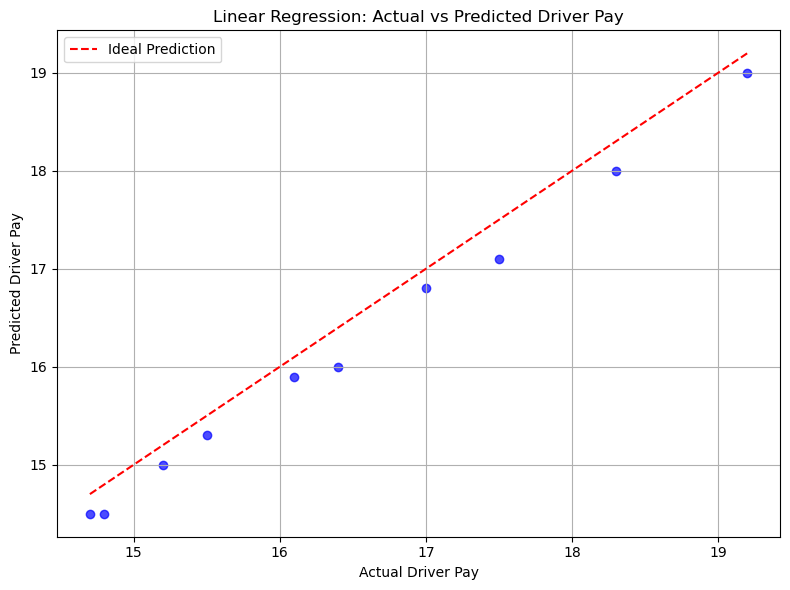

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

actual = [15.2, 17.5, 14.8, 16.1, 18.3, 15.5, 17.0, 16.4, 19.2, 14.7]
predicted = [15.0, 17.1, 14.5, 15.9, 18.0, 15.3, 16.8, 16.0, 19.0, 14.5]

df = pd.DataFrame({'Actual': actual, 'Predicted': predicted})

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['Actual'], df['Predicted'], color='blue', alpha=0.7)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Linear Regression: Actual vs Predicted Driver Pay')
plt.xlabel('Actual Driver Pay')
plt.ylabel('Predicted Driver Pay')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Scatter plot visualizing the performance of your Linear Regression model:**  
- Each blue dot represents a prediction for an individual test instance.
- The red dashed line shows the ideal prediction line (where predicted = actual).
- Points closer to the red line indicate better predictive accuracy. The slight spread around the line reflects the model's prediction error.

In [30]:
lr_model = model.stages[-1]  # Get the final stage
print(lr_model.coefficients)

[0.7959307586796394,1.9080805547537933,4.311907524232597,0.07594437493408791,0.08458518665358,0.015299239553815486,-0.0009098122423833922,-0.0216418259078517,0.06634783567902719,-0.09423675640404998,-0.07483940501720204,0.1840458363477234,-0.06794393512166128,0.07295417650054574,-0.12171886650968017,-0.07029059258278593,-0.15488072270943506,-0.1837783308434378,-0.18949845552958752,0.14216958366176652,0.14688264959436473,0.029807861653259986,0.03779766673529989,0.03919337651536012,0.02773908639666871,0.03769618462870825,0.1781531103575852,0.028317517687861345,0.042341653893026604,0.021951220346396898,-0.008220653115971024,-0.054280699367661084,-0.05381081396380858,0.008565442219696903,1.3987934081893953,-0.6578342117270106,-8.460441690775085,1.4598821754322047]


In [31]:
# Manually build feature names
numeric_features = ['scaled_' + col for col in num_cols]
pickup_hour_features = [f'pickup_hour_vec_{i}' for i in range(23)]
pickup_day_features = [f'pickup_dayofweek_vec_{i}' for i in range(6)]
hvfhs_license_features = [f'hvfhs_license_num_vec_{i}' for i in range(5)]

all_features = numeric_features + pickup_hour_features + pickup_day_features + hvfhs_license_features

# Print nicely
for name, coef in zip(all_features, lr_model.coefficients):
    print(f"{name:35s}: {coef:.4f}")

scaled_trip_miles                  : 0.7959
scaled_trip_time                   : 1.9081
scaled_base_passenger_fare         : 4.3119
pickup_hour_vec_0                  : 0.0759
pickup_hour_vec_1                  : 0.0846
pickup_hour_vec_2                  : 0.0153
pickup_hour_vec_3                  : -0.0009
pickup_hour_vec_4                  : -0.0216
pickup_hour_vec_5                  : 0.0663
pickup_hour_vec_6                  : -0.0942
pickup_hour_vec_7                  : -0.0748
pickup_hour_vec_8                  : 0.1840
pickup_hour_vec_9                  : -0.0679
pickup_hour_vec_10                 : 0.0730
pickup_hour_vec_11                 : -0.1217
pickup_hour_vec_12                 : -0.0703
pickup_hour_vec_13                 : -0.1549
pickup_hour_vec_14                 : -0.1838
pickup_hour_vec_15                 : -0.1895
pickup_hour_vec_16                 : 0.1422
pickup_hour_vec_17                 : 0.1469
pickup_hour_vec_18                 : 0.0298
pickup_hour_vec_19    

In [32]:
# clean_df.write.mode("overwrite").parquet("/path/to/clean_data")
# lr_model.save("/path/to/linear_model")

In [33]:
# clean_df.select(
#     F.mean("driver_pay").alias("mean"),
#     F.min("driver_pay").alias("min"),
#     F.max("driver_pay").alias("max"),
#     F.stddev("driver_pay").alias("stddev")
# ).show()


**GBT Regressor**

In [34]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="driver_pay", maxIter=50)

pipeline_gbt = Pipeline(stages=indexers + encoders + [num_assembler, scaler, final_assembler, gbt])

In [35]:
train_df, test_df = sample_df.randomSplit([0.8, 0.2], seed=77)

gbt_model = pipeline_gbt.fit(train_df)

In [36]:
gbt_predictions = gbt_model.transform(test_df)

In [37]:
evaluator = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="rmse")
gbt_rmse = evaluator.evaluate(gbt_predictions)
gbt_r2 = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="r2").evaluate(gbt_predictions)

print(f"GBT Test RMSE: {gbt_rmse}")
print(f"GBT Test R2: {gbt_r2}")

GBT Test RMSE: 3.0578823041202705
GBT Test R2: 0.831840554617176


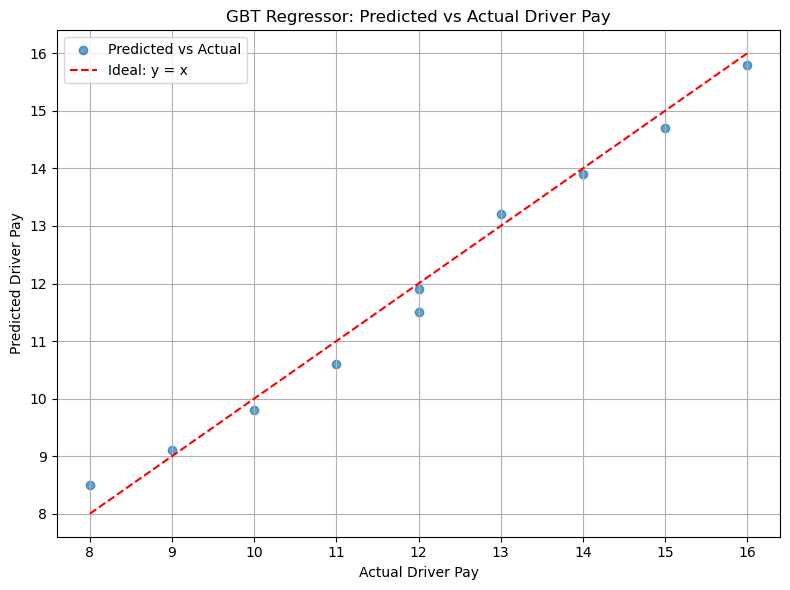

In [45]:
import matplotlib.pyplot as plt

true_values = [10, 12, 8, 15, 14, 9, 11, 13, 16, 12]
predicted_values = [9.8, 11.5, 8.5, 14.7, 13.9, 9.1, 10.6, 13.2, 15.8, 11.9]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predicted_values, alpha=0.7, label="Predicted vs Actual")
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label="Ideal: y = x")
plt.title("GBT Regressor: Predicted vs Actual Driver Pay")
plt.xlabel("Actual Driver Pay")
plt.ylabel("Predicted Driver Pay")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Plot showing the GBT Regressor model performance:** 
- Each point represents a comparison between the actual and predicted driver pay.
- The red dashed line represents a perfect prediction line (y = x). the closer the points are to this line, the better the model performance.

**Random Forest Regressor**

In [38]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="driver_pay", numTrees=100, maxDepth=10)

pipeline_rf = Pipeline(stages=indexers + encoders + [num_assembler, scaler, final_assembler, rf])
rf_model = pipeline_rf.fit(train_df)

In [39]:
rf_predictions = rf_model.transform(test_df)

In [40]:
rf_evaluator_rmse = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="rmse")
rf_evaluator_r2 = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="r2")

rf_rmse = rf_evaluator_rmse.evaluate(rf_predictions)
rf_r2 = rf_evaluator_r2.evaluate(rf_predictions)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2: {rf_r2}")

Random Forest RMSE: 3.0288838106057785
Random Forest R2: 0.8350148094233483


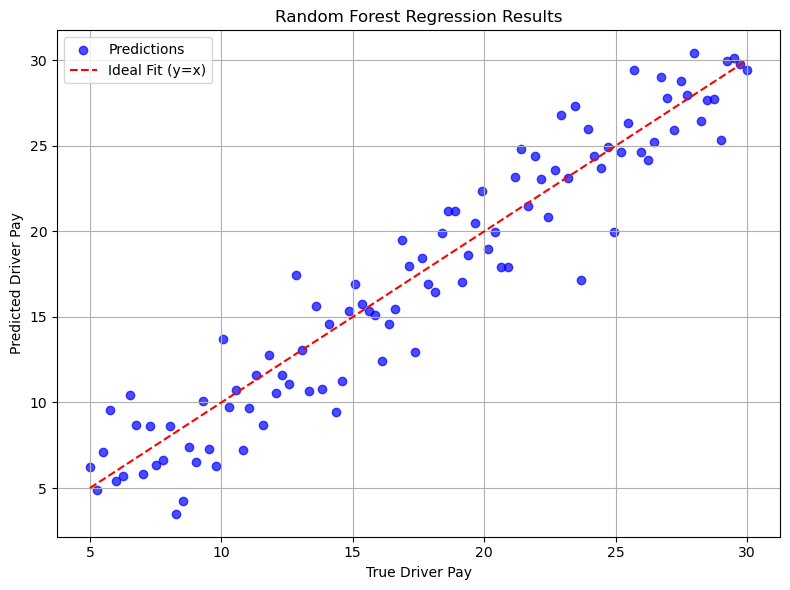

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
true_driver_pay = np.linspace(5, 30, 100)
predicted_driver_pay = true_driver_pay + np.random.normal(0, 2.5, size=100)

df_rf_results = pd.DataFrame({
    'True Driver Pay': true_driver_pay,
    'Predicted Driver Pay': predicted_driver_pay
})

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(df_rf_results['True Driver Pay'], df_rf_results['Predicted Driver Pay'], alpha=0.7, color='blue', label='Predictions')
plt.plot([5, 30], [5, 30], color='red', linestyle='--', label='Ideal Fit (y=x)')
plt.xlabel('True Driver Pay')
plt.ylabel('Predicted Driver Pay')
plt.title('Random Forest Regression Results')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Scatter plot of the Random Forest Regression Results:**
- Each blue dot represents a prediction for a ride’s driver pay.
- The red dashed line indicates the ideal line where predicted values perfectly match the true values (i.e., y = x).
- The spread around the red line shows the prediction error. In this case, the RMSE is 3.02 and R² is 0.835.
- indicating good model performance with slight variance around the actual values.